In [12]:
import os
import json
from tqdm import tqdm
import re

In [13]:
mpararel_folder = "../generated_datasets/mpararel_clean_2"
relations = [x.replace(".jsonl", "") for x in os.listdir(os.path.join(
    mpararel_folder, "en/triples"))]
langs = os.listdir(mpararel_folder)

In [41]:
def is_template_valid(template):
    """Checks that the template has one [X], one [Y], and extra text."""
    return (template.count("[X]") == 1 and
            template.count("[Y]") == 1 and
            not re.match(r'^[\b\[X\]\b\b\[Y\]\b., ]+$', template))

def get_total_phrases(mpararel_language_folder):
    total_phrases = 0
    for relation in relations:
        with open(os.path.join(mpararel_language_folder, "triples", relation + ".jsonl")) as f_triples:
            triples_count = sum([1 for line in f_triples])
        with open(os.path.join(mpararel_language_folder, "patterns", relation + ".jsonl")) as f_patterns:
            valid_patterns = 0
            for line in f_patterns:
                data = json.loads(line)
                if is_template_valid(data["pattern"]):
                    valid_patterns += 1
            if valid_patterns <= 1:
                #print("Warning: this relation ({}) should be dropped since it contains one or less patterns".format(relation))
                continue
        total_phrases += valid_patterns * triples_count
    return total_phrases

lang_to_phrases_count = {}
for lang in tqdm(langs):
    lang_to_phrases_count[lang] = get_total_phrases(
        os.path.join(mpararel_folder, lang))

100%|██████████| 104/104 [00:10<00:00,  9.55it/s]


In [23]:
import pandas as pd

In [42]:
df = pd.DataFrame(lang_to_phrases_count.items(), columns=['lang', 'phrases_count'])

In [43]:
en_total = df[df['lang'] == 'en']['phrases_count'].values[0]
df['phrases_count'] = df['phrases_count']/en_total
df

,lang,phrases_count
0,ar,0.477289
1,tr,0.438437
2,lt,0.266000
3,hu,0.539627
4,ast,0.000000
...,...,...
99,nn,0.000000
100,uk,0.481269
101,ru,0.646260
102,scn,0.000000


In [44]:
len(df)

104

In [45]:
len(df[df['phrases_count'] > 0.2])

49

In [46]:
valid_langs = df[df['phrases_count'] > 0.2]['lang'].values

In [48]:
lang_relation_templates = []
for lang in valid_langs:
    print(">>>>>>>>>>>>>>>>>>>>>")
    print(lang)
    for relation in relations:
        print("--- {} ---".format(relation))
        with open(os.path.join(mpararel_folder, lang, "patterns", relation + ".jsonl")) as f_patterns:
            patterns = set()
            for line in f_patterns:
                data = json.loads(line)
                if is_template_valid(data["pattern"]):
                    patterns.add(data["pattern"])
            print('\n'.join(patterns))
            lang_relation_templates.append([lang, relation, len(patterns)])
        print()

>>>>>>>>>>>>>>>>>>>>>
ar
--- P30 ---
[X] ينتمي إلى قارة [Y].
[X] يقع في القارة [Y].
[X] موجود في [Y].
[X] هو جزء من قارة [Y].

--- P279 ---
[X]، فئة فرعية من [Y].
[X]، وهي فئة فرعية من [Y].
[X]، نوع من [Y].
[X] هو فرعية من [Y].

--- P39 ---
[X]، الذي يحمل موقف [Y].
[X] هو [Y].
[X]، الذي هو موقف [Y].
[X]، الذي لديه موقف [Y].
[X] يحمل موقف [Y].
[X] لديه موقف [Y].

--- P1303 ---
[X] هو لاعب [Y].
[Y] لاعب [X]
[X] يلعب [Y].

--- P19 ---
[X] في الأصل من [Y].
[X] ينشأ من [Y].
[X] كان شخص [Y].
[X] ولد في [Y].
[X] كان في الأصل من [Y].
[X] كان [Y] شخص.
[X] نشأت من [Y].
[X] كان مواطني [Y].
[X] أصلي إلى [Y].
[X] هو شخص [Y].
[X]، [Y] - شخص.
[X]، [Y] شخص.

--- P101 ---
[X] مجال النشاط هو [Y].
[Y] هو تخصص [X].
[Y] هو مجال نشاط [X].
[X] متخصص في [Y].
مجال نشاط [X] هو [Y].
[Y] هي خبرة [X].
[X] مجال العمل هو [Y].
[X] يعمل في مجال [Y].
خبرات [X] هي [Y].
مجال عمل [X] هو [Y].

--- P1412 ---
[Y] هي اللغة المستخدمة من قبل [X].
[Y] هي اللغة المستخدمة عادة بواسطة [X].
[X] تستخدم [Y] للتواصل.
[X] يستخدم عادة [Y

In [142]:
df = pd.DataFrame(lang_relation_templates,
                  columns=["language", "relation", "templates_count"])

In [143]:
df["language"].unique()

array(['ar', 'tr', 'lt', 'hu', 'sl', 'hr', 'en', 'sk', 'ga', 'gl', 'nl',
       'hy', 'sq', 'ro', 'ca', 'cs', 'pl', 'it', 'zh', 'ms', 'el', 'fi',
       'et', 'fa', 'ja', 'fr', 'vi', 'eu', 'es', 'he', 'la', 'pt', 'lv',
       'hi', 'af', 'id', 'bg', 'mk', 'ka', 'bn', 'cy', 'th', 'ko', 'de',
       'az', 'da', 'uk', 'ru', 'sv'], dtype=object)

In [144]:
for relation in relations:
    en_count = df[(df["relation"] == relation) & (df["language"] == "en")]["templates_count"].values[0]
    df.loc[df["relation"] == relation, "templates_wrt_en_per_relation"] = (
        df[df["relation"] == relation]["templates_count"]/en_count)
df

,language,relation,templates_count,templates_wrt_en_per_relation
0,ar,P30,4,1.000000
1,ar,P279,4,1.000000
2,ar,P39,6,1.000000
3,ar,P1303,3,0.750000
4,ar,P19,12,0.923077
...,...,...,...,...
1906,sv,P264,15,0.882353
1907,sv,P495,17,1.000000
1908,sv,P131,3,1.000000
1909,sv,P740,14,1.000000


In [146]:
df[df["templates_wrt_en_per_relation"] <= 0.2]

,language,relation,templates_count,templates_wrt_en_per_relation
345,ga,P1001,0,0.000000
799,el,P413,0,0.000000
1150,he,P413,0,0.000000
1306,hi,P413,0,0.000000
1696,de,P413,1,0.166667


In [129]:
import matplotlib.pyplot as plt
import math
import numpy as np

/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/wsr217/mpararel/mpararel-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with Fi

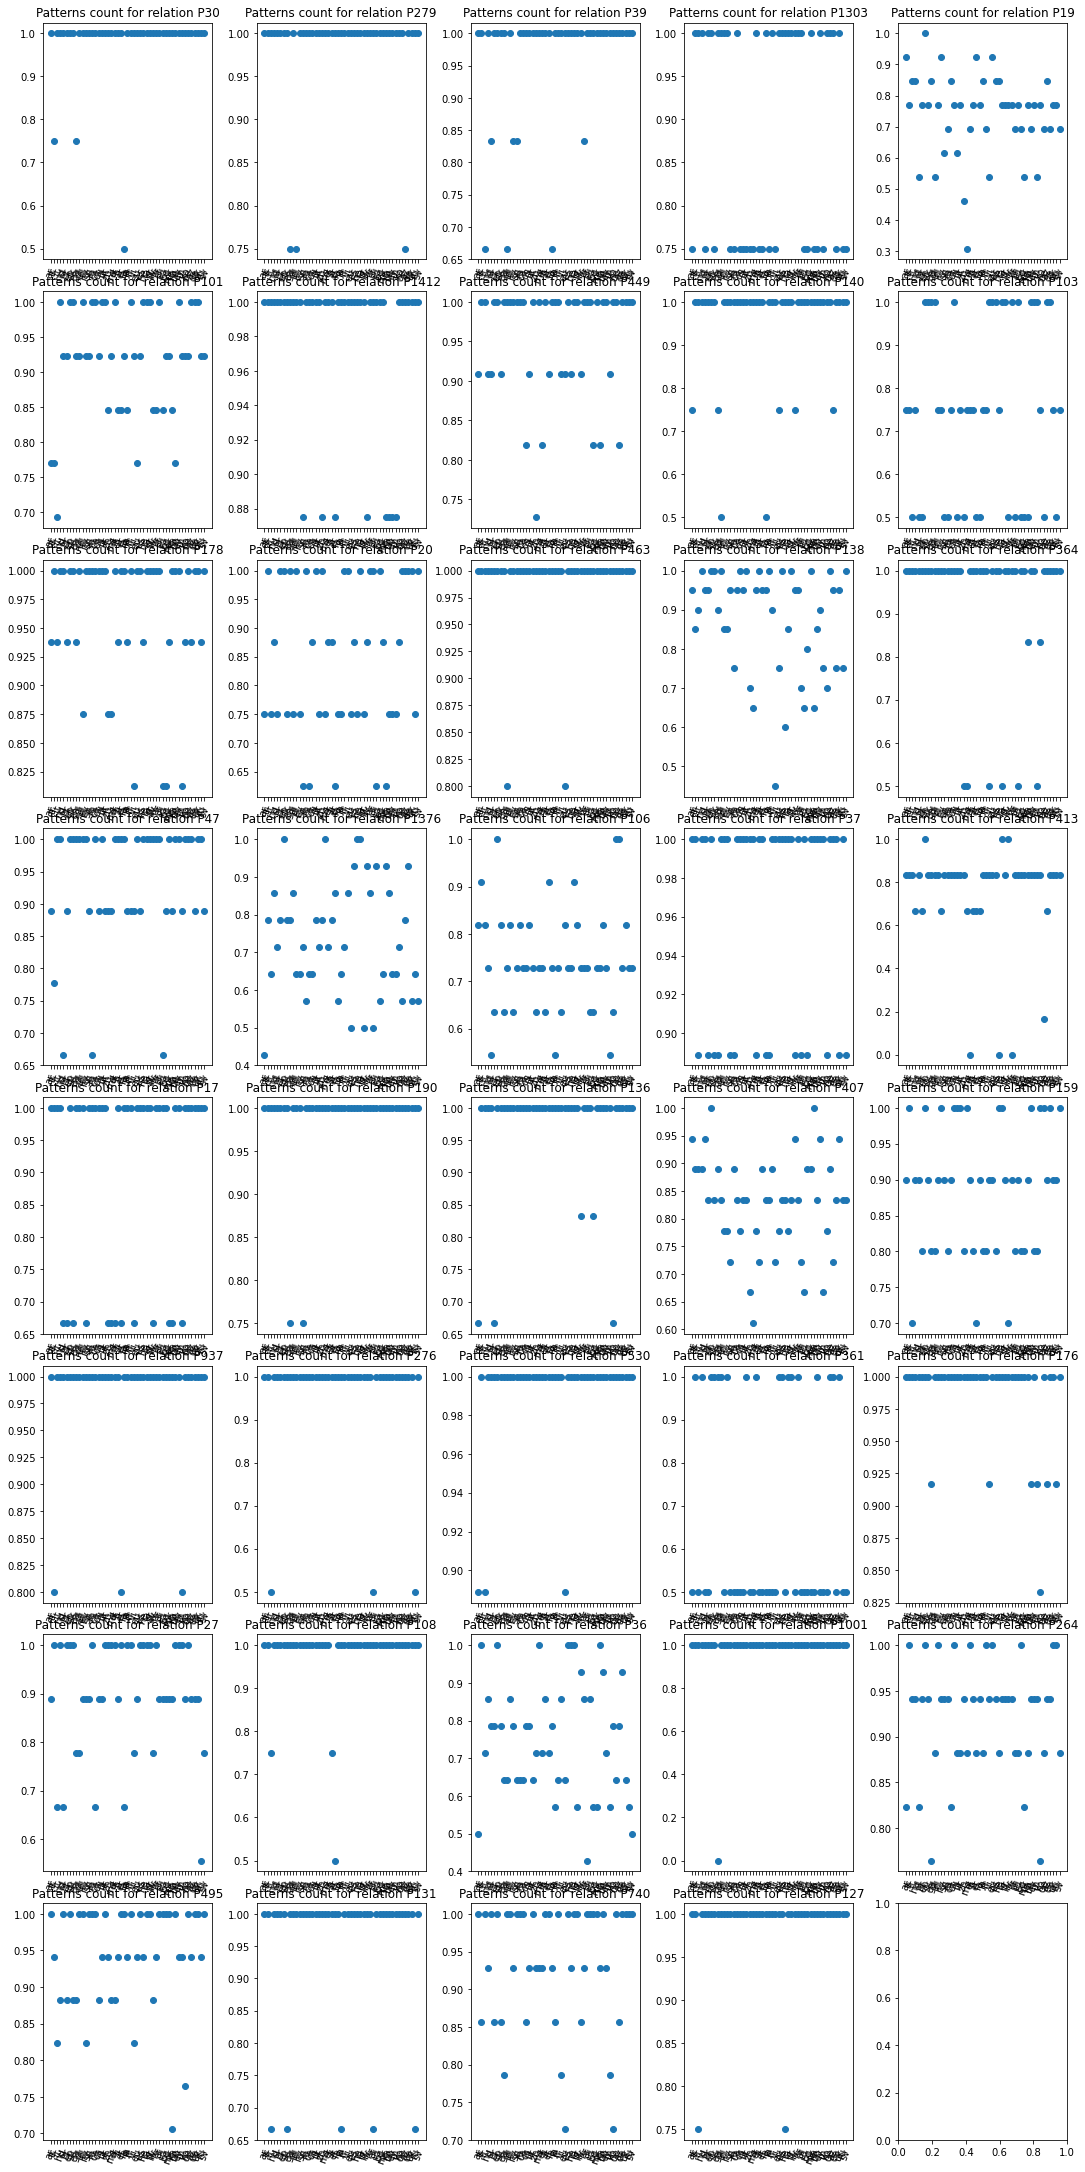

In [135]:
fig, axs = plt.subplots(math.ceil(len(relations)/5), 5, figsize=(15, 30))
fig.tight_layout()
for i, relation in enumerate(relations):
    this_relation = df[df["relation"] == relation]
    en_count = this_relation[this_relation["language"] == "en"]["templates_count"].values[0]
    axs[int(i/5)][i%5].plot(this_relation["language"].values,
                     this_relation["templates_count"].values/en_count, 'o')
    axs[int(i/5)][i%5].set_xticklabels(this_relation["language"].values, rotation=70)
    axs[int(i/5)][i%5].set_title("Patterns count for relation {}".format(relation))
plt.show()